In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import Counter

import pytz
import datetime
from statsmodels.regression.linear_model import RegressionResults
import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
import nltk
from nltk import pos_tag
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.cluster import KMeans
import re
import time

### Question 1
Report the following statistics for each hashtag, i.e. each file:

• Average number of tweets per hour

• Average number of followers of users posting the tweets per tweet (to make it simple, we average over the number of tweets; if a users posted twice, we count the user and the user’s followers twice as well)

• Average number of retweets per tweet


In [2]:
tweetFiles = ["tweets/tweets_#gohawks.txt",
              "tweets/tweets_#gopatriots.txt",
              "tweets/tweets_#nfl.txt",
              "tweets/tweets_#patriots.txt",
              "tweets/tweets_#sb49.txt",
              "tweets/tweets_#superbowl.txt" ]

In [3]:
with open(tweetFiles[0], 'r') as tweetData:
    for line in tweetData:
        parsed = json.loads(line)
        print(json.dumps(parsed, indent=4, sort_keys=True))
        break

{
    "author": {
        "author_img": "http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg",
        "description": "Married to my best friend... You-make me laugh and occasionally think... I-will let you in on some of the crazy shit that consumes my thoughts...",
        "followers": 1752.0,
        "image_url": "http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg",
        "name": "RJ",
        "nick": "rejinseattle",
        "type": "twitter",
        "url": "http://twitter.com/rejinseattle"
    },
    "citation_date": 1421518778,
    "citation_url": "http://twitter.com/REJinseattle/status/556516209261166593",
    "firstpost_date": 1419804875,
    "highlight": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
    "metrics": {
        "acceleration": 0,
        "citations": {
            "data": [
                {
                    "citations": 1,
                    "timestamp": 1421518739
                }
            ],
  

In [4]:
for tweetFile in tweetFiles:
    
    timeStamp = []
    tweetCount = 0
    followerCount = 0
    retweetCount = 0
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            timeStamp.append(data['citation_date'])
            followerCount = followerCount + (data['author']['followers'])
            retweetCount = retweetCount + (data['metrics']['citations']['total'])
            tweetCount = tweetCount + 1
        
        print(tweetFile)
        print("Avg number of tweets per hour: ", str(tweetCount/((max(timeStamp)-min(timeStamp))/3600)))
        print("Avg number of followers of poster per tweet : ", str(followerCount/tweetCount))
        print("Avg number of rewteets per tweet: ", str(retweetCount/tweetCount))



tweets/tweets_#gohawks.txt
Avg number of tweets per hour:  292.48785062173687
Avg number of followers of poster per tweet :  2217.9237355281984
Avg number of rewteets per tweet:  2.0132093991319877
tweets/tweets_#gopatriots.txt
Avg number of tweets per hour:  40.95469800606194
Avg number of followers of poster per tweet :  1427.2526051635405
Avg number of rewteets per tweet:  1.4081919101697078
tweets/tweets_#nfl.txt
Avg number of tweets per hour:  397.0213901819841
Avg number of followers of poster per tweet :  4662.37544523693
Avg number of rewteets per tweet:  1.5344602655543254
tweets/tweets_#patriots.txt
Avg number of tweets per hour:  750.89426460689
Avg number of followers of poster per tweet :  3280.4635616550277
Avg number of rewteets per tweet:  1.7852871288476946
tweets/tweets_#sb49.txt
Avg number of tweets per hour:  1276.8570598680474
Avg number of followers of poster per tweet :  10374.160292019487
Avg number of rewteets per tweet:  2.52713444111402
tweets/tweets_#superbo

### Question 2
Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt.

In [4]:
q2Files = ["tweets/tweets_#nfl.txt","tweets/tweets_#superbowl.txt"];

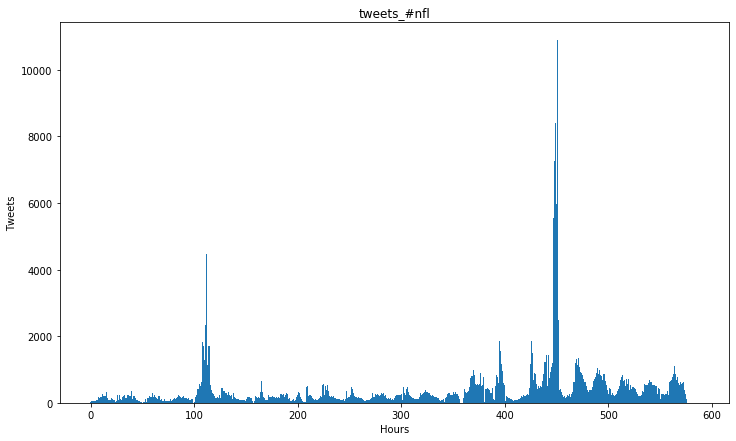

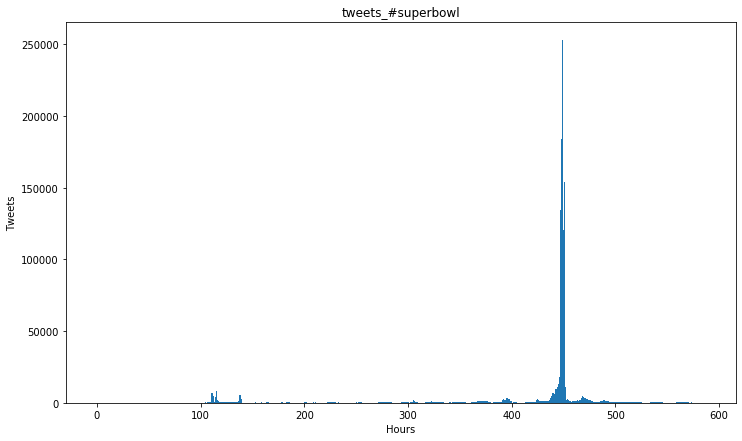

In [5]:
for tweetFile in q2Files:
    
    timeStamp = []
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            timeStamp.append(data['citation_date'])

        maxTime = max(timeStamp)
        minTime = min(timeStamp)
        timeStamp = np.rint((np.array(timeStamp) - minTime)/3600);

        plt.figure(figsize=(12,7))
        plt.bar(Counter(timeStamp).keys(), Counter(timeStamp).values(), width=1)
        plt.xlabel('Hours')
        plt.ylabel('Tweets')
        plt.title(tweetFile[7:-4])
        plt.show()



### Question 3
For each of your models, report your model’s Mean Squared Error (MSE) and R-squared measure. Also, analyse the significance of each feature using the t-test and p-value. You may use the OLS in the libarary statsmodels in Python.

In [5]:
tweetdf = []
for tweetFile in tweetFiles:
    
    tweetCount = []
    followerCount = []
    followerMaxCount = []
    retweetCount = []
    datePst = []
    hr = []
    friendsCount = []
    
    userMentions = []
    rankScore = []
    hashTags = []
    
    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            
            datePst.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz))
            
            hr.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz).hour)
            followerCount.append(data['author']['followers'])
            followerMaxCount.append(data['author']['followers'])
            retweetCount.append(data['metrics']['citations']['total'])
            tweetCount.append(1)
            
        d = {'followerCount': followerCount, 'followerMaxCount': followerMaxCount, 'retweetCount' : retweetCount,
            'tweetCount' : tweetCount, 'hr' : hr, 'datePst' : datePst}
        tweetdf.append(pd.DataFrame(data=d))

In [7]:
#np.shape(tweetdf)

In [8]:
#np.shape(tweetdf[1])
#np.shape(tweetdf[5])
#np.shape(tweetdf[4])

In [9]:
df = tweetdf[0].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max'})
# https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm

In [10]:
df['future'] = df['tweetCount']
df.future = df.future.shift(-1)

In [11]:
df.head()

,followerCount,followerMaxCount,retweetCount,tweetCount,hr,future
datePst,,,,,,
2015-01-14 00:00:00-08:00,23814.0,12922.0,459,29,0.0,13.0
2015-01-14 01:00:00-08:00,7774.0,2592.0,32,13,1.0,14.0
2015-01-14 02:00:00-08:00,26891.0,11886.0,378,14,2.0,9.0
2015-01-14 03:00:00-08:00,19094.0,11886.0,28,9,3.0,24.0
2015-01-14 04:00:00-08:00,31949.0,9772.0,62,24,4.0,29.0


In [12]:
mse1 = []
for i in np.arange(len(tweetdf)): # iterating over different hashtags
    
    tweetGroup = tweetdf[i].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr", data=tweetGroup).fit()
    print(tweetFiles[i][7:-4])
    print(model.summary())
    mse1.append((tweetFiles[i][7:-4],model.mse_resid))
    print("MSE:",model.mse_resid)


tweets_#gohawks
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     102.3
Date:                Fri, 20 Mar 2020   Prob (F-statistic):           1.10e-76
Time:                        23:40:15   Log-Likelihood:                -4663.7
No. Observations:                 569   AIC:                             9339.
Df Residuals:                     563   BIC:                             9365.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           99.5

tweets_#sb49
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     435.6
Date:                Fri, 20 Mar 2020   Prob (F-statistic):          4.54e-185
Time:                        23:40:15   Log-Likelihood:                -5231.3
No. Observations:                 536   AIC:                         1.047e+04
Df Residuals:                     530   BIC:                         1.050e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          235.0748

In [13]:
for i in np.arange(len(mse1)):
    print(mse1[i])

('tweets_#gohawks', 778598.8815298489)
('tweets_#gopatriots', 36467.259832186704)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.518126629)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051512)


### Question 4
Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting MSE and significance of features.

In [6]:
tweetdf = []
for tweetFile in tweetFiles:
    
    tweetCount = []
    followerCount = []
    followerMaxCount = []
    retweetCount = []
    datePst = []
    hr = []
    friendsCount = []
    
    userMentions = []
    rankScore = []
    hashTags = []
    
    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            
            datePst.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz))
            
            hr.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz).hour)
            followerCount.append(data['author']['followers'])
            followerMaxCount.append(data['author']['followers'])
            retweetCount.append(data['metrics']['citations']['total'])
            tweetCount.append(1)
            
            userMentions.append(len(data['tweet']['entities']['user_mentions']))
            rankScore.append(data['metrics']['ranking_score'])
            hashTags.append(len(data['tweet']['entities']['hashtags']))
            friendsCount.append(data['tweet']['user']['friends_count'])
            #url_count.append(extract_link(data))
            
        d = {'followerCount': followerCount, 'followerMaxCount': followerMaxCount, 'retweetCount' : retweetCount,
            'tweetCount' : tweetCount, 'hr' : hr, 'datePst' : datePst,
            'userMentions' : userMentions, 'rankScore' : rankScore, 'hashTags' : hashTags,'friendsCount':friendsCount}
        tweetdf.append(pd.DataFrame(data=d))

tweets_#gohawks
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     104.6
Date:                Sat, 21 Mar 2020   Prob (F-statistic):          8.36e-114
Time:                        17:47:21   Log-Likelihood:                -4566.6
No. Observations:                 569   AIC:                             9153.
Df Residuals:                     559   BIC:                             9197.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -61.6

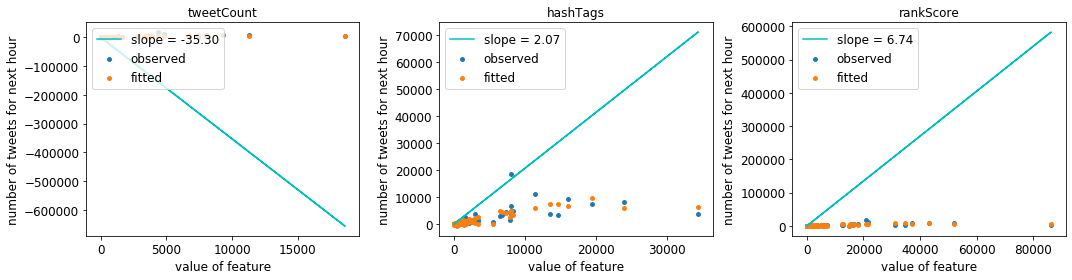

tweets_#gopatriots
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     237.2
Date:                Sat, 21 Mar 2020   Prob (F-statistic):          1.18e-160
Time:                        17:47:22   Log-Likelihood:                -2756.3
No. Observations:                 440   AIC:                             5533.
Df Residuals:                     430   BIC:                             5573.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -

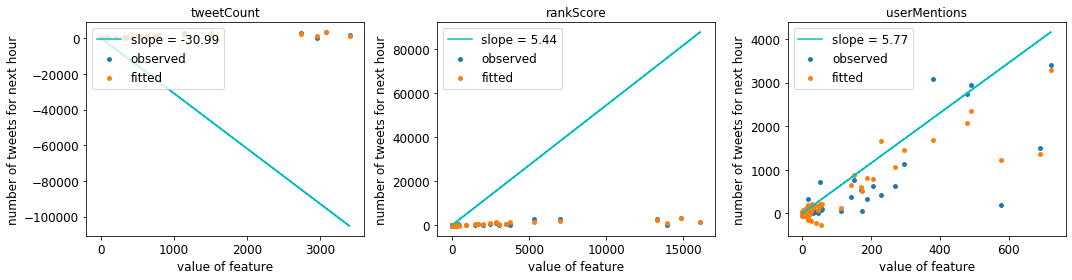

tweets_#nfl
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     107.6
Date:                Sat, 21 Mar 2020   Prob (F-statistic):          5.78e-117
Time:                        17:47:22   Log-Likelihood:                -4424.4
No. Observations:                 582   AIC:                             8869.
Df Residuals:                     572   BIC:                             8912.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          121.3742 

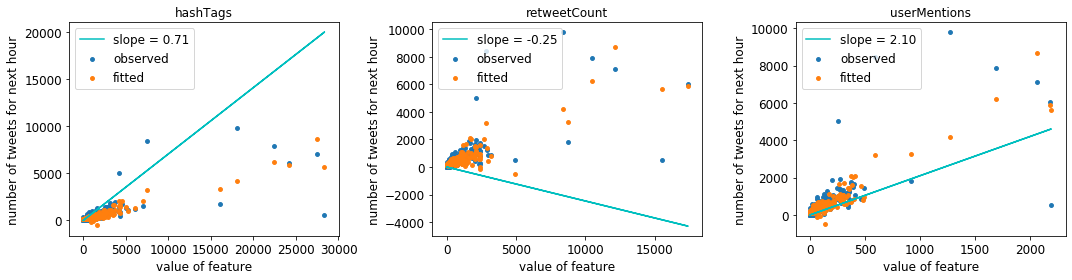

tweets_#patriots
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     280.5
Date:                Sat, 21 Mar 2020   Prob (F-statistic):          5.09e-204
Time:                        17:47:23   Log-Likelihood:                -5191.7
No. Observations:                 586   AIC:                         1.040e+04
Df Residuals:                     576   BIC:                         1.045e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -384.

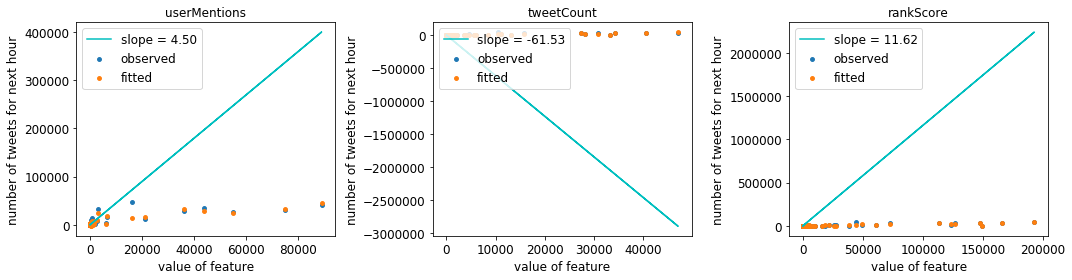

tweets_#sb49
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     406.2
Date:                Sat, 21 Mar 2020   Prob (F-statistic):          2.54e-230
Time:                        17:47:23   Log-Likelihood:                -5112.8
No. Observations:                 536   AIC:                         1.025e+04
Df Residuals:                     526   BIC:                         1.029e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -301.0109

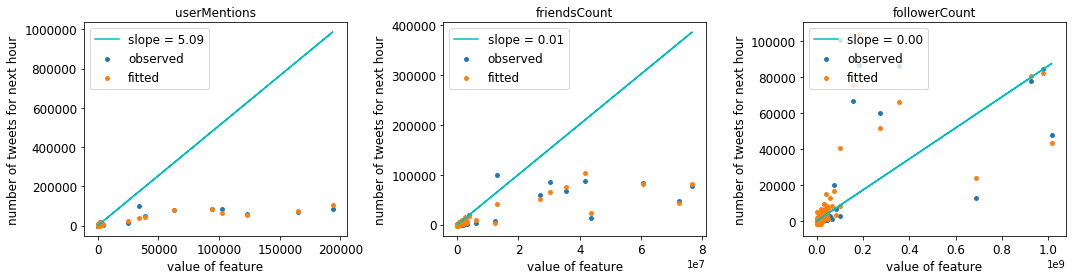

tweets_#superbowl
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     497.3
Date:                Sat, 21 Mar 2020   Prob (F-statistic):          5.93e-265
Time:                        17:47:24   Log-Likelihood:                -5875.0
No. Observations:                 586   AIC:                         1.177e+04
Df Residuals:                     576   BIC:                         1.181e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -721

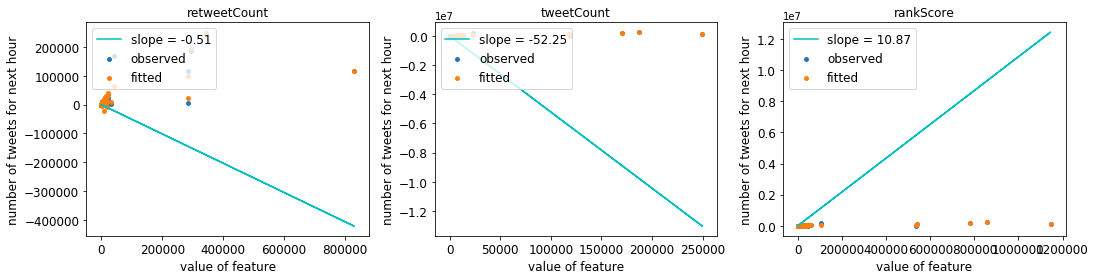

In [7]:
features = ['followerCount','followerMaxCount','retweetCount','tweetCount','hr',
        'userMentions','rankScore','hashTags','friendsCount']


mse2 = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags+friendsCount", data=tweetGroup).fit()
    predict = model.predict(tweetGroup)
    print(tweetFiles[i][7:-4])
    print(model.summary())
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    print("MSE:",model.mse_resid)
    
    featuresSorted = []
    pVals = model.pvalues[1:]
    
    for j in np.arange(len(features)):
        featuresSorted.append((pVals[j], features[j]))
    featuresSorted.sort(key = lambda x: x[0]) 
    
    top_features = featuresSorted[:3]
    
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    for j,feature in enumerate(top_features):
        
        slope = model.params[feature[1]]
        ax[j].scatter(tweetGroup[feature[1]],tweetGroup['future'], label='observed', s=15)
        ax[j].scatter(tweetGroup[feature[1]],predict,label='fitted', s=15)
        ax[j].plot(np.array(tweetGroup[feature[1]]),np.array(tweetGroup[feature[1]]) * slope,'c', label='slope = {:.2f}'.format(slope))
        ax[j].set_title(feature[1])
        ax[j].set_xlabel('value of feature', fontsize=12)
        ax[j].set_ylabel('number of tweets for next hour', fontsize=12)
        ax[j].legend(loc='upper left', fontsize=12)
        ax[j].tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

In [16]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")


#Note MSE1 is different, only for comparision only!

for i in np.arange(len(mse2)):
    print(mse2[i])

('tweets_#gohawks', 778598.8815298489)
('tweets_#gopatriots', 36467.259832186704)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.518126629)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051512)


('tweets_#gohawks', 557502.6511403514)
('tweets_#gopatriots', 16544.495874875443)
('tweets_#nfl', 238853.15962877145)
('tweets_#patriots', 2953028.2059895173)
('tweets_#sb49', 11509232.06780086)
('tweets_#superbowl', 30414001.984979782)


In [17]:
print(featuresSorted)

[(5.1874697520232856e-17, 'retweetCount'), (6.236193475130101e-15, 'tweetCount'), (1.4056401765944427e-14, 'rankScore'), (1.1239360439631574e-12, 'hashTags'), (1.3621178578040756e-06, 'friendsCount'), (9.243630528315476e-05, 'userMentions'), (0.0535798812929348, 'followerCount'), (0.5610387785606867, 'followerMaxCount'), (0.795179031648355, 'hr')]


### Question 5
For each of the top 3 features (i.e. with the smallest p-values) in your measurements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that feature, using all the samples you have extracted, and analyze it. Do the regression coefficients agree with the trends in the plots? If not, why?

In [18]:
# See question 4, Yuan

tweets_#gohawks


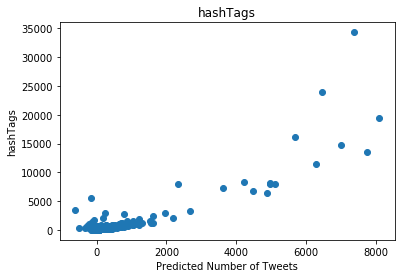

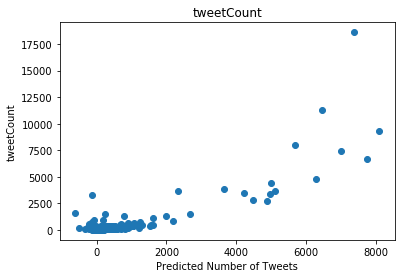

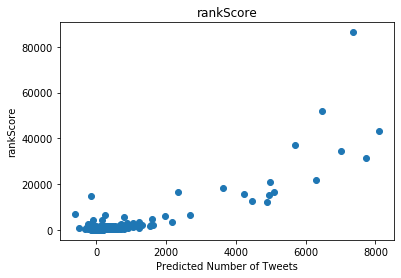

tweets_#gopatriots


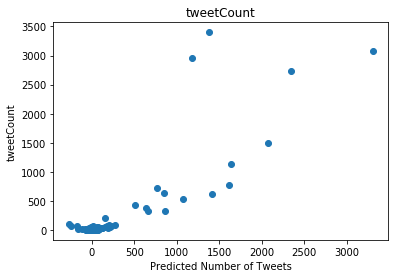

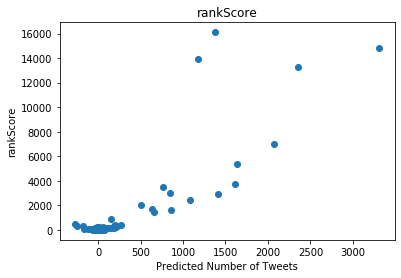

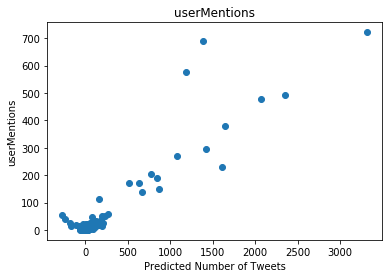

tweets_#nfl


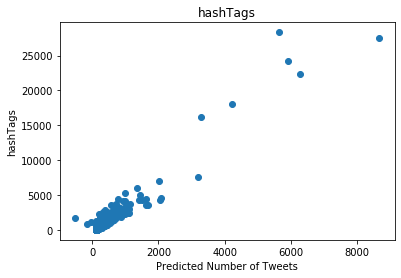

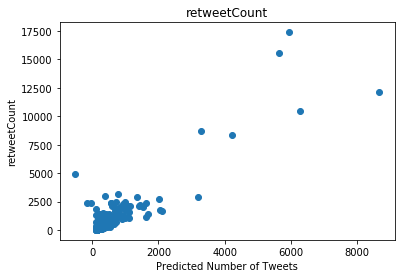

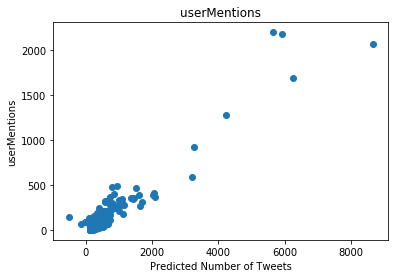

tweets_#patriots


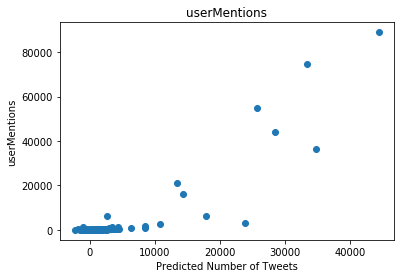

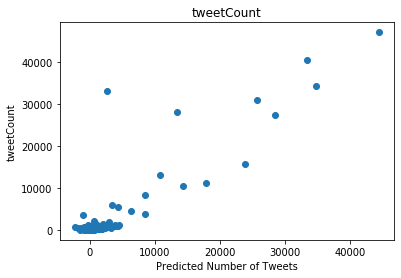

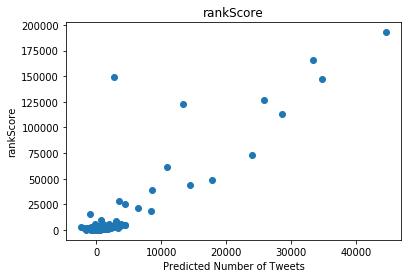

tweets_#sb49


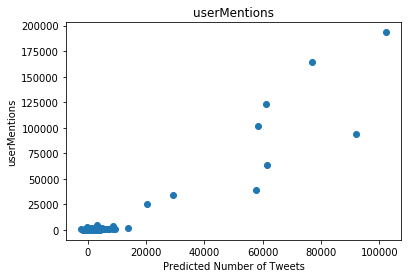

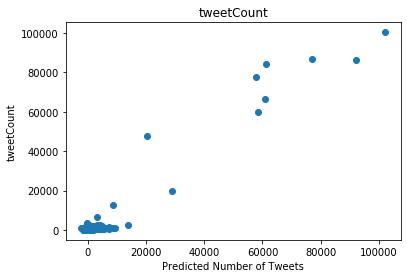

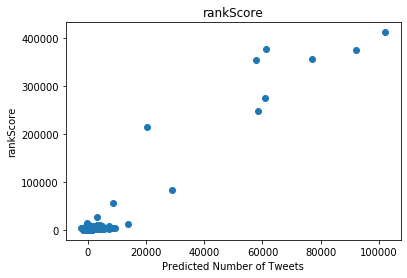

tweets_#superbowl


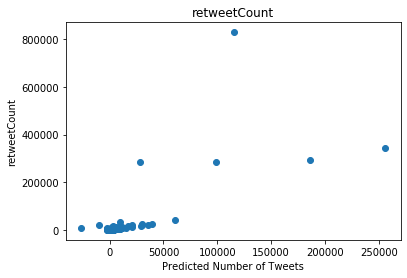

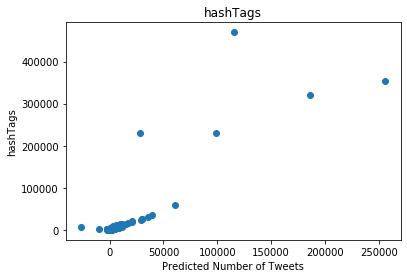

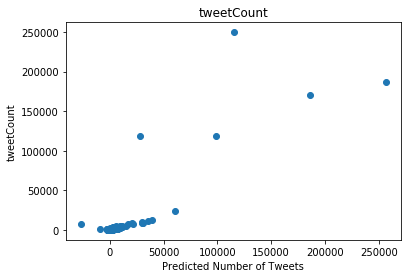

In [19]:
features = ['followerCount','followerMaxCount','retweetCount','tweetCount','hr',
        'userMentions','rankScore','hashTags']
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=tweetGroup).fit()
    predict = model.predict(tweetGroup)
    
    print(tweetFiles[i][7:-4])
    
    featuresSorted = []
    pVals = model.pvalues[1:]
    for j in np.arange(len(features)):
        featuresSorted.append((pVals[j], features[j]))
    featuresSorted.sort(key = lambda x: x[0]) 

    for j in np.arange(3):
        plt.scatter(predict, tweetGroup[featuresSorted[j][1]])
        plt.title(featuresSorted[j][1])
        plt.xlabel("Predicted Number of Tweets")
        plt.ylabel(featuresSorted[j][1])
        plt.show()

### Question 6
We define three time periods and their corresponding window length as follows:
1. Before Feb. 1, 8:00 a.m.: 1-hour window
2. Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window
3. After Feb. 1, 8:00 p.m.: 1-hour window


In [20]:
## P1
mse2 = []
rsquare = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] < '2015-02-01 08:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags+friendsCount", data=tweetGroup).fit()
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    rsquare.append(model.rsquared)

In [21]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")
for i in np.arange(len(mse2)):
    print("MSE: " + str(mse2[i]) + " R2 " + str(rsquare[i]))

('tweets_#gohawks', 778598.8815298489)
('tweets_#gopatriots', 36467.259832186704)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.518126629)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051512)


MSE: ('tweets_#gohawks', 391105.3899799492) R2 0.629266834738023
MSE: ('tweets_#gopatriots', 1477.3658262621261) R2 0.6915445325138287
MSE: ('tweets_#nfl', 64709.41632815778) R2 0.5315809809711172
MSE: ('tweets_#patriots', 317534.04964227515) R2 0.6028339234339768
MSE: ('tweets_#sb49', 6356.710596400901) R2 0.8916078476085276
MSE: ('tweets_#superbowl', 456265.5647931369) R2 0.48330089273290067


In [22]:
## P2
mse2 = []
rsquare = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] >= '2015-02-01 08:00:00-0800') &
                       (tweetdf[i]['datePst'] <= '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags+friendsCount", data=tweetGroup).fit()
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    rsquare.append(model.rsquared)

In [23]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")
for i in np.arange(len(mse2)):
    print("MSE: " + str(mse2[i]) + " R2 " + str(rsquare[i]))

('tweets_#gohawks', 778598.8815298489)
('tweets_#gopatriots', 36467.259832186704)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.518126629)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051512)


MSE: ('tweets_#gohawks', 71138.7846234019) R2 0.5336165997212333
MSE: ('tweets_#gopatriots', 14076.07849124971) R2 0.5001952534942797
MSE: ('tweets_#nfl', 20072.04152915557) R2 0.8383959090489244
MSE: ('tweets_#patriots', 671394.0045288597) R2 0.7306070071834287
MSE: ('tweets_#sb49', 1140446.8293864676) R2 0.8896157691937968
MSE: ('tweets_#superbowl', 4036515.2752992073) R2 0.9398788329703858


In [24]:
## P3
mse2 = []
rsquare = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] >= '2015-02-01 20:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags+friendsCount", data=tweetGroup).fit()
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    rsquare.append(model.rsquared)

In [25]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")
for i in np.arange(len(mse2)):
    print("MSE: " + str(mse2[i]) + " R2 " + str(rsquare[i]))

('tweets_#gohawks', 778598.8815298489)
('tweets_#gopatriots', 36467.259832186704)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.518126629)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051512)


MSE: ('tweets_#gohawks', 1941.8159496097876) R2 0.8497619359111352
MSE: ('tweets_#gopatriots', 73.65007648622402) R2 0.8496286940311808
MSE: ('tweets_#nfl', 17283.561177576128) R2 0.8032452039337872
MSE: ('tweets_#patriots', 10763.318127165816) R2 0.8892539422639684
MSE: ('tweets_#sb49', 49019.716555399355) R2 0.8762788468259243
MSE: ('tweets_#superbowl', 110904.13511191847) R2 0.855737520287607


### Michael's original code

### Question 7
Also, aggregate the data of all hashtags, and train 3 models (for the intervals mentioned above) to predict the number of tweets in the next time window on the aggregated data.

Perform the same evaluations on your combined model and compare with models you trained for individual hashtags.


In [26]:
## P1
combinedTweetGroupDf = []
combinedTweetGroupDfTruth = []
combinedTweetGroupDfPredict = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] < '2015-02-01 08:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDf.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 08:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 09:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfTruth.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 07:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 08:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfPredict.append(tweetGroup)

combinedTweetGroup = pd.concat(combinedTweetGroupDf)
combinedTweetGroupTruth = pd.concat(combinedTweetGroupDfTruth)
combinedTweetGroupPredict = pd.concat(combinedTweetGroupDfPredict)

model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags + friendsCount", data=combinedTweetGroup).fit()

print("Predicted: ")
print(model.predict(combinedTweetGroupPredict))
print("Truth: ")
print(combinedTweetGroupTruth['tweetCount'])

Predicted: 
datePst
2015-02-01 07:00:00-08:00     129.023131
2015-02-01 07:00:00-08:00      69.400755
2015-02-01 07:00:00-08:00    1190.012218
2015-02-01 07:00:00-08:00     493.906148
2015-02-01 07:00:00-08:00    1750.535976
2015-02-01 07:00:00-08:00    6204.014857
dtype: float64
Truth: 
datePst
2015-02-01 08:00:00-08:00     231
2015-02-01 08:00:00-08:00      31
2015-02-01 08:00:00-08:00     847
2015-02-01 08:00:00-08:00     435
2015-02-01 08:00:00-08:00    1629
2015-02-01 08:00:00-08:00    5031
Freq: 60T, Name: tweetCount, dtype: int64


In [27]:
## P2
combinedTweetGroupDf = []
combinedTweetGroupDfTruth = []
combinedTweetGroupDfPredict = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] >= '2015-02-01 08:00:00-0800') &
                       (tweetdf[i]['datePst'] <= '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDf.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 20:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 20:05:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfTruth.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 19:55:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfPredict.append(tweetGroup)

combinedTweetGroup = pd.concat(combinedTweetGroupDf)
combinedTweetGroupTruth = pd.concat(combinedTweetGroupDfTruth)
combinedTweetGroupPredict = pd.concat(combinedTweetGroupDfPredict)

model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=combinedTweetGroup).fit()

print("Predicted: ")
print(model.predict(combinedTweetGroupPredict))
print("Truth: ")
print(combinedTweetGroupTruth['tweetCount'])

Predicted: 
datePst
2015-02-01 19:55:00-08:00    365.166773
2015-02-01 19:55:00-08:00    354.648465
2015-02-01 19:55:00-08:00    379.376916
2015-02-01 19:55:00-08:00    380.559267
2015-02-01 19:55:00-08:00    403.048833
2015-02-01 19:55:00-08:00    976.815456
dtype: float64
Truth: 
datePst
2015-02-01 20:00:00-08:00     33
2015-02-01 20:00:00-08:00      7
2015-02-01 20:00:00-08:00     27
2015-02-01 20:00:00-08:00    148
2015-02-01 20:00:00-08:00    241
2015-02-01 20:00:00-08:00    194
Freq: 5T, Name: tweetCount, dtype: int64


In [28]:
## P3
combinedTweetGroupDf = []
combinedTweetGroupDfTruth = []
combinedTweetGroupDfPredict = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] >= '2015-02-01 20:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDf.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-07 10:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-07 11:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfTruth.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-07 10:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-07 11:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfPredict.append(tweetGroup)

combinedTweetGroup = pd.concat(combinedTweetGroupDf)
combinedTweetGroupTruth = pd.concat(combinedTweetGroupDfTruth)
combinedTweetGroupPredict = pd.concat(combinedTweetGroupDfPredict)

model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=combinedTweetGroup).fit()

print("Predicted: ")
print(model.predict(combinedTweetGroupPredict))
print("Truth: ")
print(combinedTweetGroupTruth['tweetCount'])

Predicted: 
datePst
2015-02-07 10:00:00-08:00    29.777283
2015-02-07 10:00:00-08:00    32.736918
2015-02-07 10:00:00-08:00    62.212445
2015-02-07 10:00:00-08:00    29.767759
dtype: float64
Truth: 
datePst
2015-02-07 10:00:00-08:00     5
2015-02-07 10:00:00-08:00     3
2015-02-07 10:00:00-08:00    43
2015-02-07 10:00:00-08:00     1
Name: tweetCount, dtype: int64


### Yuan's approach Q7

In [30]:
#I first aggregate everything, then do regression.

features = ['followerCount','followerMaxCount','retweetCount','tweetCount','hr',
        'userMentions','rankScore','hashTags','friendsCount']

tweetdf_agg = []

tweetCount_agg = []
followerCount_agg = []
followerMaxCount_agg = []
retweetCount_agg = []
datePst_agg = []
hr_agg = []
friendsCount_agg = []
    
userMentions_agg = []
rankScore_agg = []
hashTags_agg = []

for tweetFile in tweetFiles:
    
    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            
            datePst_agg.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz))
            
            hr_agg.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz).hour)
            followerCount_agg.append(data['author']['followers'])
            followerMaxCount_agg.append(data['author']['followers'])
            retweetCount_agg.append(data['metrics']['citations']['total'])
            tweetCount_agg.append(1)
            
            userMentions_agg.append(len(data['tweet']['entities']['user_mentions']))
            rankScore_agg.append(data['metrics']['ranking_score'])
            hashTags_agg.append(len(data['tweet']['entities']['hashtags']))
            friendsCount_agg.append(data['tweet']['user']['friends_count'])
            #url_count.append(extract_link(data))
            
d = {'followerCount': followerCount_agg, 'followerMaxCount': followerMaxCount_agg, 'retweetCount' : retweetCount_agg,
            'tweetCount' : tweetCount_agg, 'hr' : hr_agg, 'datePst' : datePst_agg,
            'userMentions' : userMentions_agg, 'rankScore' : rankScore_agg, 'hashTags' : hashTags_agg,'friendsCount':friendsCount_agg}

tweetdf_agg = pd.DataFrame(data=d)


In [30]:
#tweetdf_agg

In [8]:
tweetdf_agg_group_before = tweetdf_agg[(tweetdf_agg['datePst'] < '2015-02-01 08:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
tweetdf_agg_group_before['future'] = tweetdf_agg_group_before['tweetCount']
tweetdf_agg_group_before.future = tweetdf_agg_group_before.future.shift(-1)

In [9]:
model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags + friendsCount", data=tweetdf_agg_group_before).fit()
predict = model.predict(tweetdf_agg_group_before)
print('MSE is {}'.format(metrics.mean_squared_error(tweetdf_agg_group_before['future'].replace(np.nan, 0).values, predict.values)))

MSE is 4199491.171860169


In [10]:
tweetdf_agg_group_before.to_csv('aggregated_data_before.csv')

In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 future   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     41.84
Date:                Sat, 21 Mar 2020   Prob (F-statistic):           1.83e-53
Time:                        10:54:02   Log-Likelihood:                -3959.3
No. Observations:                 439   AIC:                             7939.
Df Residuals:                     429   BIC:                             7980.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          233.1055    205.580      1.134      0.257    -170.963     637.174
followerCount     -3.19e-05   1.31e-05     -2.430      0.016   -5.77e-05    -6.1e-06
followerMaxCount  6.286e-05    5.8e-05      1.083      0.279   -5.12e-05       0.000
retweetCount        -0.0743      0.072     -1.031      0.303      -0.216       0.067
tweetCount          -5.3792      2.237     -2.405      0.017      -9.775      -0.983
hr                   4.2623     14.380      0.296      0.767     -24.002      32.527
userMentions         0.1330      0.647      0.206      0.837      -1.138       1.404
rankScore            1.4340      0.479      2.995      0.003       0.493       2.375
hashTags            -0.6728      0.227     -2.960      0.003      -1.119      -0.226
friendsCount         0.0014      0.000      5.587      0.000       0.001       0.002
==============================================================================
Omnibus:                      794.268   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           566396.863
Skew:                          11.158   Prob(JB):                         0.00
Kurtosis:                     177.547   Cond. No.                     5.63e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
#tweetdf_agg_group_before

In [13]:
#window #1

tweetdf_agg_group_between = tweetdf_agg[(tweetdf_agg['datePst'] >= '2015-02-01 08:00:00-0800') &
                       (tweetdf_agg['datePst'] <= '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
tweetdf_agg_group_between['future'] = tweetdf_agg_group_between['tweetCount']
tweetdf_agg_group_between.future = tweetdf_agg_group_between.future.shift(-1)

In [15]:
model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags + friendsCount", data=tweetdf_agg_group_between).fit()
predict = model.predict(tweetdf_agg_group_between)
print('MSE is {}'.format(metrics.mean_squared_error(tweetdf_agg_group_between['future'].replace(np.nan, 0).values, predict.values)))

MSE is 12365455.931601226


In [16]:
tweetdf_agg_group_between.to_csv('aggregated_data_between.csv')

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 future   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     125.8
Date:                Sat, 21 Mar 2020   Prob (F-statistic):           1.40e-60
Time:                        11:06:03   Log-Likelihood:                -1368.2
No. Observations:                 143   AIC:                             2756.
Df Residuals:                     133   BIC:                             2786.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -5475.0604   1647.565     -3.323      0.001   -8733.881   -2216.240
followerCount    -2.732e-05   1.52e-05     -1.803      0.074   -5.73e-05    2.65e-06
followerMaxCount  6.061e-05   5.42e-05      1.119      0.265   -4.65e-05       0.000
retweetCount        -0.1046      0.025     -4.104      0.000      -0.155      -0.054
tweetCount           3.1862      4.135      0.770      0.442      -4.993      11.365
hr                 715.1628    163.350      4.378      0.000     392.063    1038.262
userMentions         0.3455      0.196      1.766      0.080      -0.042       0.733
rankScore           -0.1683      0.823     -0.205      0.838      -1.795       1.459
hashTags            -1.2333      0.290     -4.251      0.000      -1.807      -0.659
friendsCount         0.0011      0.000      4.368      0.000       0.001       0.002
==============================================================================
Omnibus:                       29.499   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.414
Skew:                           0.866   Prob(JB):                     1.03e-14
Kurtosis:                       5.794   Cond. No.                     6.62e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.62e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
tweetdf_agg_group_after = tweetdf_agg[(tweetdf_agg['datePst'] > '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
tweetdf_agg_group_after['future'] = tweetdf_agg_group_after['tweetCount']
tweetdf_agg_group_after.future = tweetdf_agg_group_after.future.shift(-1)

In [20]:
model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags + friendsCount", data=tweetdf_agg_group_after).fit()
predict = model.predict(tweetdf_agg_group_after)
print('MSE is {}'.format(metrics.mean_squared_error(tweetdf_agg_group_after['future'].replace(np.nan, 0).values, predict.values)))

MSE is 344440.4261445609


In [23]:
tweetdf_agg_group_after.to_csv('aggregated_data_after.csv')

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 future   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     114.4
Date:                Sat, 21 Mar 2020   Prob (F-statistic):           1.11e-55
Time:                        11:07:57   Log-Likelihood:                -1044.7
No. Observations:                 134   AIC:                             2109.
Df Residuals:                     124   BIC:                             2138.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          464.0657    133.978      3.464      0.001     198.885     729.247
followerCount     2.138e-05   6.49e-06      3.296      0.001    8.54e-06    3.42e-05
followerMaxCount  1.318e-05   2.01e-05      0.656      0.513   -2.66e-05    5.29e-05
retweetCount        -0.0399      0.010     -4.043      0.000      -0.059      -0.020
tweetCount          -9.9542      1.866     -5.335      0.000     -13.647      -6.261
hr                  -7.7186      8.129     -0.949      0.344     -23.808       8.371
userMentions         0.8729      0.336      2.595      0.011       0.207       1.539
rankScore            2.0412      0.372      5.490      0.000       1.305       2.777
hashTags             0.4133      0.176      2.345      0.021       0.064       0.762
friendsCount        -0.0001      0.000     -1.105      0.271      -0.000    9.94e-05
==============================================================================
Omnibus:                      107.445   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1682.505
Skew:                           2.540   Prob(JB):                         0.00
Kurtosis:                      19.599   Cond. No.                     1.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
tweetdf_agg_group_all = tweetdf_agg.groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
tweetdf_agg_group_all['future'] = tweetdf_agg_group_all['tweetCount']
tweetdf_agg_group_all.future = tweetdf_agg_group_all.future.shift(-1)

In [34]:
tweetdf_agg_group_all.to_csv('aggregated_data_all.csv')

## Q8:
Use grid search to find the best parameter set for RandomForestRegressor and
GradientBoostingRegressor respectively. Use the following param grid

In [14]:
def gridsearch_all(reg, param_grid,scale):
    grid = GridSearchCV(reg, param_grid=param_grid,
                        cv=KFold(5, shuffle=True, random_state=42),
                        scoring='neg_mean_squared_error', n_jobs=-3)
    summary = []
    
    data_agg = pd.read_csv('aggregated_data_all.csv')
    y = np.nan_to_num(data_agg['future'])
    X = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])
        
    if scale == True:
        scaler = StandardScaler()
        X_scale = scaler.fit_transform(X)
    else:
        X_scale = X
    
    grid.fit(X_scale, y)
    results = grid.cv_results_
    results_df = pd.DataFrame({'_'.join(['mean_test_score', 'all']): -results['mean_test_score'],'_'.join(['params', 'all']): results['params'],'_'.join(['rank', 'all']): results['rank_test_score']}).sort_values(by='_'.join(['rank', 'all'])).reset_index(drop=True)
    summary.append(results_df)
    summary_df = pd.concat(summary, axis=1)
    return summary_df

In [149]:
# %% Q8: random forest, grid search, this code takes 2 hours using 10CPUS
param_grid = {'max_depth': [10, 30, 50, 70, 100,200, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2,3, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': np.arange(200,2000,200)}

reg = RandomForestRegressor()
summary_df_q8 = gridsearch_all(reg, param_grid,scale = False)

In [150]:
summary_df_q8.head()

,mean_test_score_all,params_all,rank_all
0,1.936304e+08,"{'max_depth': 30, 'max_features': 'auto', 'min...",1
1,1.972456e+08,"{'max_depth': 70, 'max_features': 'auto', 'min...",2
2,1.981726e+08,"{'max_depth': 30, 'max_features': 'auto', 'min...",3
3,1.983259e+08,"{'max_depth': 70, 'max_features': 'auto', 'min...",4
4,1.986180e+08,"{'max_depth': 200, 'max_features': 'auto', 'mi...",5


In [153]:
summary_df_q8.to_csv('q8_results_rf.csv')

In [55]:
summary_df_q8.to_csv('q8_results.csv')

In [147]:
# Q8: GradientBoostingRegressor, grid search, this code takes 2 hours using 10CPUS
param_grid = {'max_depth': [10, 30, 50, 70, 100,200, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2,3, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': np.arange(200,2000,200)}

reg = GradientBoostingRegressor()
summary_df_q8_gb = gridsearch_all(reg, param_grid,scale = False)

NameError: name 'summary_df_q8' is not defined

In [148]:
print(summary_df_q8_gb.head())
summary_df_q8_gb.to_csv('q8_results_gb.csv')

   mean_test_score_all                                         params_all  \
0         1.904649e+08  {'max_depth': 10, 'max_features': 'auto', 'min...   
1         1.946441e+08  {'max_depth': 50, 'max_features': 'auto', 'min...   
2         1.993674e+08  {'max_depth': 100, 'max_features': 'auto', 'mi...   
3         2.008733e+08  {'max_depth': 200, 'max_features': 'auto', 'mi...   
4         2.012602e+08  {'max_depth': 70, 'max_features': 'auto', 'min...   

   rank_all  
0         1  
1         2  
2         3  
3         4  
4         5  


## QUESTION 9: 
Compare the best estimator you found in the grid search with OLS on the entire
dataset.

In [158]:
model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags + friendsCount", data=tweetdf_agg_group_all).fit()
predict = model.predict(tweetdf_agg_group_all)
print('MSE is {}'.format(metrics.mean_squared_error(tweetdf_agg_group_all['future'].replace(np.nan, 0).values, predict.values)))

MSE is 104287407.87131238


In [166]:
data_agg = pd.read_csv('aggregated_data_all.csv')
y = np.nan_to_num(data_agg['future'])
X = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

reg = RandomForestRegressor(max_depth = 30,max_features = 'auto',min_samples_leaf= 1, min_samples_split = 5, n_estimators = 200)
reg.fit(X, y)
print(metrics.mean_squared_error(y, reg.predict(X)))

54910229.942220435


## QUESTION 10: 
For each time period described in Question 6, perform the same grid search
above for GradientBoostingRegressor (with corresponding time window length). Does the cross-
validation test error change? Are the best parameter set you find in each period agree with those
you found above?

In [140]:
def gridsearch_periods(reg, param_grid,scale,window_6X):
    grid = GridSearchCV(reg, param_grid=param_grid,
                        cv=KFold(5, shuffle=True, random_state=42),
                        scoring='neg_mean_squared_error', n_jobs=-3)
    summary = []
    for i, period in enumerate(['before', 'between', 'after']):
        if window_6X == False:
            data_agg = pd.read_csv('aggregated_data_{}.csv'.format(period))
        else:
            data_agg = pd.read_csv('aggregated_data_6X_{}.csv'.format(period))
            
        y = np.nan_to_num(data_agg['future'])
        X = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])
            
        if scale == True:
            scaler = StandardScaler()
            X_scale = scaler.fit_transform(X)
        else:
            X_scale = X
            
        grid.fit(X_scale, y)
        results = grid.cv_results_
        results_df = pd.DataFrame(
            {'_'.join(['mean_test_score', period]): -results['mean_test_score'],
             '_'.join(['params', period]): results['params'],
             '_'.join(['rank', period]): results['rank_test_score']
             }).sort_values(by='_'.join(['rank', period])
                            ).reset_index(drop=True)
        summary.append(results_df)
    summary_df = pd.concat(summary, axis=1)
    return summary_df

In [ ]:
# %% Q10: random forest, grid search, this code takes 1.5 hours using 10CPUS
param_grid = {'max_depth': [10, 30, 50, 70, 100,200, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2,3, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': np.arange(200,2000,200)}

reg_rf = RandomForestRegressor()
summary_df_rf_q10 = gridsearch_periods(reg_rf, param_grid,scale = False, window_6X = False)

reg_gb = GradientBoostingRegressor()
summary_df_gb_q10 = gridsearch_periods(reg_gb, param_grid,scale = False, window_6X = False)


summary_df_rf_q10.to_csv('Q10_summary_df_rf.csv')
summary_df_gb_q10.to_csv('Q10_summary_df_gb.csv')

In [41]:
summary_df_gb.head()

,mean_test_score_before,params_before,rank_before,mean_test_score_between,params_between,rank_between,mean_test_score_after,params_after,rank_after
0,4.369976e+06,"{'max_depth': None, 'max_features': 'auto', 'm...",1,2.033652e+07,"{'max_depth': 200, 'max_features': 'sqrt', 'mi...",1,403388.702594,"{'max_depth': 70, 'max_features': 'sqrt', 'min...",1
1,4.370755e+06,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2,2.064284e+07,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2,403679.783918,"{'max_depth': 200, 'max_features': 'sqrt', 'mi...",2
2,4.374846e+06,"{'max_depth': 200, 'max_features': 'auto', 'mi...",3,2.131849e+07,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",3,404690.363256,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",3
3,4.410523e+06,"{'max_depth': 200, 'max_features': 'auto', 'mi...",4,2.142775e+07,"{'max_depth': None, 'max_features': 'sqrt', 'm...",4,405921.156079,"{'max_depth': 200, 'max_features': 'sqrt', 'mi...",4
4,4.428094e+06,"{'max_depth': 70, 'max_features': 'auto', 'min...",5,2.144853e+07,"{'max_depth': 200, 'max_features': 'sqrt', 'mi...",5,406637.430664,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",5


## QUESTION 11: 
Now try to regress the aggregated data with MLPRegressor. Try different
architectures (i.e. the structure of the network) by adjusting hidden layer sizes. You should try
at least 5 architectures with various numbers of layers and layer sizes. Report the architectures you
tried, as well as its MSE of fitting the entire aggregated data.

In [15]:
# %% 
param_grid = {'hidden_layer_sizes':[(20,3), (50,3), (100,3), (200,3),(20,5), (50,5), (100,5), (200,5), (20, 10), (50, 10),(100,10),(200,10),(20, 20), (50, 20),(100,20),(200,20)]}
#param_grid = {'hidden_layer_sizes':[(20,), (50,), (100,), (200,),(300,), (400,)]}
reg_nn = MLPRegressor(max_iter=10000)
summary_df_nn_unscaled_q11 = gridsearch_all(reg_nn, param_grid, scale = False)

In [16]:
summary_df_nn_unscaled_q11.head()

,mean_test_score_all,params_all,rank_all
0,2.754076e+09,"{'hidden_layer_sizes': (100, 5)}",1
1,3.420778e+09,"{'hidden_layer_sizes': (50, 5)}",2
2,3.730592e+09,"{'hidden_layer_sizes': (200, 3)}",3
3,4.107108e+09,"{'hidden_layer_sizes': (20, 3)}",4
4,4.956976e+09,"{'hidden_layer_sizes': (200, 5)}",5


In [17]:
summary_df_nn_unscaled_q11.to_csv('q11_nn_all.csv')

## QUESTION 12: 
Use StandardScaler to scale the features before feeding it to MLPRegressor (with the best architecture you got above). Does its performance increase?

In [145]:
data_agg = pd.read_csv('aggregated_data_all.csv')
y = np.nan_to_num(data_agg['future'])
X = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

reg = MLPRegressor(hidden_layer_sizes=(100,5),max_iter=40000)
reg.fit(X_scale, y)
print(metrics.mean_squared_error(y, reg.predict(X_scale)))

20596182.75913672


In [146]:
# compared to without transform
data_agg = pd.read_csv('aggregated_data_all.csv')
y = np.nan_to_num(data_agg['future'])
X = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

reg = MLPRegressor(hidden_layer_sizes=(100,5),max_iter=40000)
reg.fit(X, y)
print(metrics.mean_squared_error(y, reg.predict(X)))

817728050.3374853


In [18]:
# %% 
param_grid = {'hidden_layer_sizes':[(20,3), (50,3), (100,3), (200,3),(20,5), (50,5), (100,5), (200,5), (20, 10), (50, 10),(100,10),(200,10),(20, 20), (50, 20),(100,20),(200,20)]}
#param_grid = {'hidden_layer_sizes':[(20,), (50,), (100,), (200,),(300,), (400,)]}
reg_nn = MLPRegressor(max_iter=10000)
summary_df_nn_scaled = gridsearch_all(reg_nn, param_grid, scale = True)

In [19]:
summary_df_nn_scaled.head()

,mean_test_score_all,params_all,rank_all
0,3.593918e+06,"{'hidden_layer_sizes': (50, 20)}",1
1,3.844345e+06,"{'hidden_layer_sizes': (200, 10)}",2
2,3.857567e+06,"{'hidden_layer_sizes': (100, 20)}",3
3,4.030666e+06,"{'hidden_layer_sizes': (200, 20)}",4
4,4.056099e+06,"{'hidden_layer_sizes': (200, 5)}",5


In [20]:
summary_df_nn_scaled.to_csv('q12_scaled_data.csv')

## QUESTION 13: 
Using grid search, find the best architecture (for scaled data) for each period (with corresponding window length) described in Question 6.

In [25]:
param_grid = {'hidden_layer_sizes':[(20,3), (50,3), (100,3), (200,3),(20,5), (50,5), (100,5), (200,5), (20, 10), (50, 10),(100,10),(200,10),(20, 20), (50, 20),(100,20),(200,20)]}
#param_grid = {'hidden_layer_sizes':[(20,), (50,), (100,), (200,),(300,), (400,)]}
reg_nn = MLPRegressor(max_iter=40000)
#summary_df_nn_scaled = gridsearch_all(reg_nn, param_grid,scale = False)
summary_df_nn_scaled_q13 = gridsearch_periods(reg_nn,param_grid, scale = True, window_6X = False)

In [26]:
summary_df_nn_scaled_q13.head()

,mean_test_score_before,params_before,rank_before,mean_test_score_between,params_between,rank_between,mean_test_score_after,params_after,rank_after
0,5.589335e+06,"{'hidden_layer_sizes': (50, 10)}",1,3.472962e+07,"{'hidden_layer_sizes': (200, 10)}",1,673534.418617,"{'hidden_layer_sizes': (200, 10)}",1
1,5.985370e+06,"{'hidden_layer_sizes': (20, 5)}",2,4.113224e+07,"{'hidden_layer_sizes': (100, 5)}",2,698619.624771,"{'hidden_layer_sizes': (50, 20)}",2
2,6.556631e+06,"{'hidden_layer_sizes': (50, 5)}",3,4.802936e+07,"{'hidden_layer_sizes': (50, 10)}",3,718112.747641,"{'hidden_layer_sizes': (200, 20)}",3
3,7.168136e+06,"{'hidden_layer_sizes': (20, 3)}",4,5.040548e+07,"{'hidden_layer_sizes': (100, 20)}",4,799439.752888,"{'hidden_layer_sizes': (200, 5)}",4
4,7.859446e+06,"{'hidden_layer_sizes': (20, 20)}",5,5.812881e+07,"{'hidden_layer_sizes': (50, 20)}",5,834301.935977,"{'hidden_layer_sizes': (20, 20)}",5


In [27]:
summary_df_nn_scaled_q13.to_csv('q13_scaled_grid_search_periods.csv')

## QUESTION 14: 
Report the model you use. For each test file, provide your predictions on the
number of tweets in the next time window.

In [126]:
# Process test datafiles to get the statistics
tweetFiles_q14 = ["sample data/sample0_period1.txt",
                  "sample data/sample1_period1.txt",
                  "sample data/sample2_period1.txt",
                  "sample data/sample0_period2.txt",
                  "sample data/sample1_period2.txt",
                  "sample data/sample2_period2.txt",
                  "sample data/sample0_period3.txt",
                  "sample data/sample1_period3.txt",
                  "sample data/sample2_period3.txt"]

In [137]:
tweetdf_q14 = []

all_tweetCount = []
all_followerCount = []
all_followerMaxCount = []
all_retweetCount = []
all_hr = []
all_friendsCount = []
all_periodName = []
all_userMentions = []
all_rankScore = []
all_hashTags = []
all_sample = []

for tweetFile in tweetFiles_q14:
    
    tweetCount = []
    followerCount = []
    followerMaxCount = []
    retweetCount = []
    datePst = []
    hr = []
    friendsCount = []
    
    userMentions = []
    rankScore = []
    hashTags = []
    

    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            
            datePst.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz))
            
            hr.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz).hour)
            followerCount.append(data['author']['followers'])
            followerMaxCount.append(data['author']['followers'])
            retweetCount.append(data['metrics']['citations']['total'])
            tweetCount.append(1)
            
            userMentions.append(len(data['tweet']['entities']['user_mentions']))
            rankScore.append(data['metrics']['ranking_score'])
            hashTags.append(len(data['tweet']['entities']['hashtags']))
            friendsCount.append(data['tweet']['user']['friends_count'])
    
    periodName = int(tweetFile[tweetFile.find(".")-1:tweetFile.find(".")])
    
    all_followerCount.append(np.sum(followerCount))
    all_followerMaxCount.append(max(followerMaxCount))
    all_retweetCount.append(np.sum(retweetCount))
    all_tweetCount.append(np.sum(tweetCount))
    all_hr.append(max(hr))
    all_userMentions.append(np.sum(userMentions))
    all_rankScore.append(np.sum(rankScore))
    all_hashTags.append(np.sum(hashTags))
    all_friendsCount.append(np.sum(friendsCount))
    all_periodName.append(periodName)
    all_sample.append(tweetFile[tweetFile.find("/")+1:tweetFile.find("_")])
d = {'followerCount': all_followerCount, 'followerMaxCount': all_followerMaxCount, 'retweetCount' : all_retweetCount,
         'tweetCount' : all_tweetCount, 'hr' : all_hr,'userMentions' : all_userMentions, 'rankScore' :all_rankScore,
         'hashTags' : all_hashTags,'friendsCount':all_friendsCount,'period':all_periodName,'sample':all_sample}
#print(d)
df_sample_file = pd.DataFrame(d)
df_sample_file.to_csv('test_statistics.csv')

{'followerCount': [17002159.0, 20229495.0, 5597749.0, 71767249.0, 21651304.0, 3402478.0, 4600024.0, 12936528.0, 13870610.0], 'followerMaxCount': [5883161.0, 1813823.0, 2288647.0, 9184266.0, 5044900.0, 1019357.0, 3329958.0, 9677129.0, 9677129.0], 'retweetCount': [2159, 4851, 2304, 25776, 8844, 500, 609, 1574, 1741], 'tweetCount': [568, 2280, 953, 13377, 5549, 152, 410, 305, 399], 'hr': [10, 6, 22, 19, 12, 8, 5, 23, 22], 'userMentions': [348, 1059, 450, 2837, 9113, 123, 118, 83, 122], 'rankScore': [2652.3833038, 10333.251200499999, 4308.7581161, 60666.1604839, 23162.596820500003, 740.3231840999999, 1771.7884851, 1300.6945524, 1746.7508656], 'hashTags': [1526, 5710, 2006, 24942, 11259, 364, 1138, 953, 1182], 'friendsCount': [1071458, 3480381, 841762, 11666605, 2569797, 383492, 624247, 416988, 656469], 'period': [1, 1, 1, 2, 2, 2, 3, 3, 3], 'sample': ['sample0', 'sample1', 'sample2', 'sample0', 'sample1', 'sample2', 'sample0', 'sample1', 'sample2']}


In [138]:
df_sample_file

,followerCount,followerMaxCount,retweetCount,tweetCount,hr,userMentions,rankScore,hashTags,friendsCount,period,sample
0,17002159.0,5883161.0,2159,568,10,348,2652.383304,1526,1071458,1,sample0
1,20229495.0,1813823.0,4851,2280,6,1059,10333.251200,5710,3480381,1,sample1
2,5597749.0,2288647.0,2304,953,22,450,4308.758116,2006,841762,1,sample2
3,71767249.0,9184266.0,25776,13377,19,2837,60666.160484,24942,11666605,2,sample0
4,21651304.0,5044900.0,8844,5549,12,9113,23162.596821,11259,2569797,2,sample1
5,3402478.0,1019357.0,500,152,8,123,740.323184,364,383492,2,sample2
6,4600024.0,3329958.0,609,410,5,118,1771.788485,1138,624247,3,sample0
7,12936528.0,9677129.0,1574,305,23,83,1300.694552,953,416988,3,sample1
8,13870610.0,9677129.0,1741,399,22,122,1746.750866,1182,656469,3,sample2


In [98]:
tweetdf_q14= pd.DataFrame(data=d)

In [99]:
tweetdf_q14

,followerCount,followerMaxCount,retweetCount,tweetCount,hr,datePst,userMentions,rankScore,hashTags,friendsCount
0,98191.0,98191.0,1,1,5,2015-01-31 05:00:37-08:00,0,7.686219,3,2601
1,158.0,158.0,1,1,5,2015-01-31 05:01:19-08:00,0,3.971872,3,246
2,187.0,187.0,1,1,5,2015-01-31 05:08:03-08:00,1,4.188179,1,9
3,1352.0,1352.0,1,1,5,2015-01-31 05:10:02-08:00,0,4.301411,1,998
4,1427.0,1427.0,2,1,5,2015-01-31 05:10:18-08:00,1,4.266692,4,673
...,...,...,...,...,...,...,...,...,...,...
23988,305.0,305.0,1,1,22,2015-02-05 22:16:53-08:00,1,3.427246,1,736
23989,82.0,82.0,1,1,22,2015-02-05 22:17:57-08:00,3,3.765978,1,261
23990,301.0,301.0,1,1,22,2015-02-05 22:19:23-08:00,0,3.554645,3,15
23991,257.0,257.0,1,1,22,2015-02-05 22:32:56-08:00,2,3.791177,1,101


In [141]:
# Prepare training set at 6X window as well
tweetdf_agg_group_before = tweetdf_agg[(tweetdf_agg['datePst'] < '2015-02-01 08:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='360Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
tweetdf_agg_group_before['future'] = tweetdf_agg_group_before['tweetCount']
tweetdf_agg_group_before.future = tweetdf_agg_group_before.future.shift(-1)
tweetdf_agg_group_before.to_csv('aggregated_data_6X_before.csv')

tweetdf_agg_group_between = tweetdf_agg[(tweetdf_agg['datePst'] >= '2015-02-01 08:00:00-0800') &
                       (tweetdf_agg['datePst'] <= '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='30Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
tweetdf_agg_group_between['future'] = tweetdf_agg_group_between['tweetCount']
tweetdf_agg_group_between.future = tweetdf_agg_group_between.future.shift(-1)
tweetdf_agg_group_between.to_csv('aggregated_data_6X_between.csv')


tweetdf_agg_group_after = tweetdf_agg[(tweetdf_agg['datePst'] > '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='360Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum',
        'friendsCount':'sum'})
tweetdf_agg_group_after['future'] = tweetdf_agg_group_after['tweetCount']
tweetdf_agg_group_after.future = tweetdf_agg_group_after.future.shift(-1)

tweetdf_agg_group_after.to_csv('aggregated_data_6X_after.csv')

In [142]:
# Q14 let's train a random forest regressor
param_grid = {'max_depth': [10, 30, 50, 70,100,200,None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [2,3, 4,5],
                  'min_samples_split': [2,3,4,5],
                  'n_estimators': np.arange(200,2000,200)}

reg_q14 = RandomForestRegressor()
summary_df_q14 = gridsearch_periods(reg_q14, param_grid,scale = False,window_6X = True)
summary_df_q14.to_csv('Q14_trained_random_forest_new.csv')

In [172]:

# took the best model and fit training data
reg_before =  RandomForestRegressor(max_depth=200, max_features= 'sqrt', min_samples_leaf =  5, min_samples_split =  2, n_estimators =  200)
reg_between =  RandomForestRegressor(max_depth=300, max_features= 'auto', min_samples_leaf =  2, min_samples_split =  3, n_estimators =  200)
reg_after =  RandomForestRegressor(max_depth=70, max_features= 'auto', min_samples_leaf =  2, min_samples_split =  3, n_estimators =  200)

data_agg = pd.read_csv('aggregated_data_6X_before.csv')
y_before = np.nan_to_num(data_agg['future'])
X_before = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])
reg_before.fit(X_before, y_before)

data_agg = pd.read_csv('aggregated_data_6X_between.csv')
y_between = np.nan_to_num(data_agg['future'])
X_between = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])
reg_between.fit(X_between, y_between)

data_agg = pd.read_csv('aggregated_data_6X_after.csv')
y_after = np.nan_to_num(data_agg['future'])
X_after = np.nan_to_num(data_agg[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])
reg_after.fit(X_after, y_after)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [173]:
# Now let's make some prediction for the next time frame for the test sample

reg_before.predict(df_sample_file.query("period==1 and sample== 'sample0'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([5745.62301204])

In [176]:
reg_before.predict(df_sample_file.query("period==1 and sample== 'sample1'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([6435.67853627])

In [177]:
reg_before.predict(df_sample_file.query("period==1 and sample== 'sample2'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([3455.49127703])

In [179]:
reg_between.predict(df_sample_file.query("period==2 and sample== 'sample0'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([12472.936125])

In [180]:
reg_between.predict(df_sample_file.query("period==2 and sample== 'sample1'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([11010.03989881])

In [181]:
reg_between.predict(df_sample_file.query("period==2 and sample== 'sample2'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([8647.04456548])

In [182]:
reg_after.predict(df_sample_file.query("period==3 and sample== 'sample0'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([2938.40788095])

In [183]:
reg_after.predict(df_sample_file.query("period==3 and sample== 'sample1'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([1546.51132143])

In [184]:
reg_after.predict(df_sample_file.query("period==3 and sample== 'sample2'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])

array([1546.51132143])

In [186]:
model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags + friendsCount", data=tweetdf_agg_group_before).fit()
predict = model.predict(df_sample_file.query("period==1 and sample== 'sample0'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])
print(predict)

0    4311.338029
dtype: float64


In [187]:
model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags + friendsCount", data=tweetdf_agg_group_before).fit()
predict = model.predict(df_sample_file.query("period==1 and sample== 'sample1'")[['followerCount','followerMaxCount','retweetCount','tweetCount','hr','userMentions','rankScore','hashTags','friendsCount']])
print(predict)

1    7325.057276
dtype: float64
